In [1]:
import scvelo as scv

In [2]:
adata = scv.read('../trails/checkpoints/VelocityDemo/0602_210418/model_last.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'assigned_t', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'dpt_pseudotime', 'latent_time', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_inter', 'velocity_gamma', 'velocity_r2', 'scaling', 'velocity_genes', 'fit_vars', 'fit_varu', 'fit_gamma', 'fit_beta', 'fit_offset', 'fit_a', 'fit_t', 'fit_h', 'fit_intercept', 'fit_sr2', 'fit_ur2'
    uns: 'basis', 'clusters_colors', 'diffmap_evals', 'iroot', 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'velocity_tsne'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'Mu_scale', 'Pred_s', 'Pred_u', 'fit_t', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

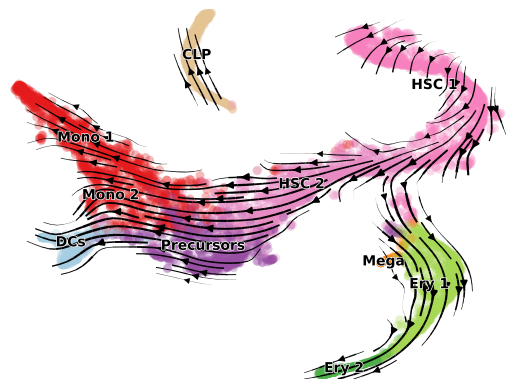

In [7]:
scv.pl.velocity_embedding_stream(adata, color='clusters', dpi=100, title='')

computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


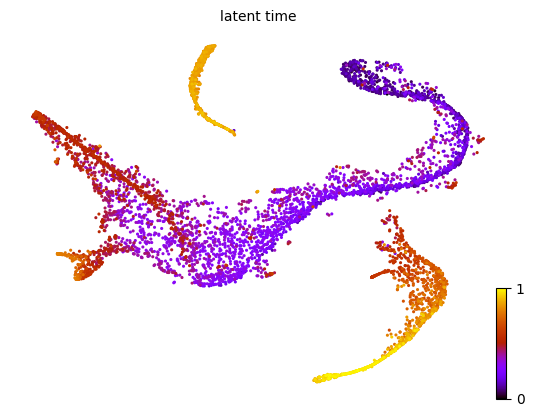

In [8]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

In [1]:
import os
import sys 
package_path = os.path.abspath(os.path.join('..', 'unitvelo'))
sys.path.append(package_path)
from main import run_model 

2024-06-16 21:23:00.153034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 21:23:00.301298: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 21:23:00.305216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-16 21:23:00.305235: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
from logger import setup_logging
config = setup_logging()
run_model(config)

Inferring RNA velocity with scATAC-seq data
Using adata file from /data/nelkazwi/RNA_velo/Unitvelo_atac/test_multivelo_data/RNA_data.h5ad

Filtered out 23217 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Extracted 2000 highly variable genes
Computing moments for 2000 genes with n_neighbors: 30 and n_pcs: 30

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
B size =  (50, 2000)
# of velocity genes 1813 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 1614 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)

# of velocity genes 1599 (Criterion: genes have reads in more than 5% of total cells)

Use diffusion pseudotime for cell time initialization.


2024-06-16 21:23:27.963327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-06-16 21:23:27.963484: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-16 21:23:27.965815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
L

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.